# Instance Segmentation
In this tutorial, you will learn:
 - the basic structure of RTMDet.
 - to perform inference with a MMDetection detector.
 - to train a new instance segmentation model with a new dataset.

Let's start!

In [ ]:
import IPython.display as display

%pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

%pip install -e .
display.clear_output()

In [ ]:
# import wandb
# wandb.login()

# Perform Inference with An MMDetection Detector
A one-stage detector
In this tutorial, we use RTMDet, a simple one-stage detector as an example.

The high-level architecture of RTMDet is shown in the following picture. More details can be found in the [paper](https://arxiv.org/abs/2212.07784).

![RTMDet Architecture.jpg](https://s2.loli.net/2023/07/27/FXGfswZayTKOmpc.jpg)

RTMDet not only achieves the best parameter-accuracy trade-off on object detection from tiny to extra-large model sizes but also obtains new state-of-the-art performance on instance segmentation and rotated object detection tasks.

In [ ]:
!mkdir ./checkpoints
!mim download mmdet --config rtmdet-ins_l_8xb32-300e_coco --dest ./checkpoints

processing rtmdet-ins_l_8xb32-300e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 MiB 17.1 MB/s eta 0:00:00
Successfully downloaded rtmdet-ins_l_8xb32-300e_coco_20221124_103237-78d1d652.pth to /content/mmdetection/checkpoints
Successfully dumped rtmdet-ins_l_8xb32-300e_coco.py to /content/mmdetection/checkpoints


# Inference with the detector
The model is successfully created and loaded, let's see how good it is. We use the high-level API inference_detector implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

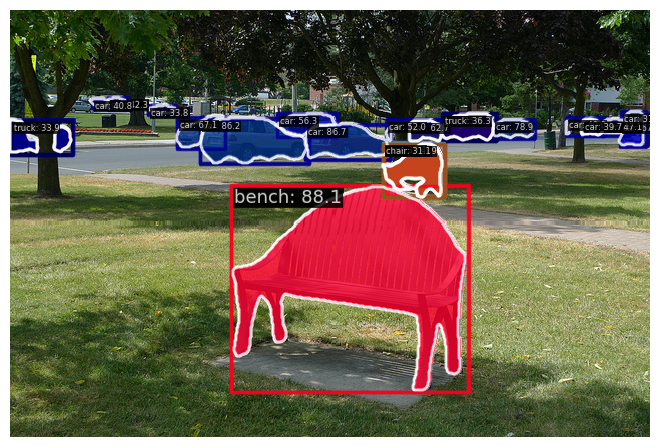

In [ ]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

config_file = 'configs/rtmdet/rtmdet-ins_l_8xb32-300e_coco.py'

checkpoint_file = 'checkpoints/rtmdet-ins_l_8xb32-300e_coco_20221124_103237-78d1d652.pth'

register_all_modules()

model = init_detector(config_file, checkpoint_file, device='cuda:0')

image = mmcv.imread('demo/demo.jpg',channel_order='rgb')
result = inference_detector(model, image)

from mmdet.registry import VISUALIZERS
visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

visualizer.add_datasample('result',image,data_sample=result,draw_gt = None,wait_time=0,)

display.clear_output()
visualizer.show()

# Train a Detector on A Customized Dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector

## Support a new dataset

There are three ways to support a new dataset in MMDetection:
  1. Reorganize the dataset into a COCO format
  2. Reorganize the dataset into a middle format
  3. Implement a new dataset

We recommend the first two methods, as they are usually easier than the third.

In this tutorial, we give an example that converts the data into COCO format because MMDetection **only support evaluating mask AP of dataset in COCO format for now**. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/advanced_guides/customize_dataset.html).

First, let's download the [the balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon).

In [ ]:
!wget -c https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip balloon_dataset.zip -d ./ballondatasets/
!tree ballondatasets
display.clear_output()

## Data exploration and visualisation

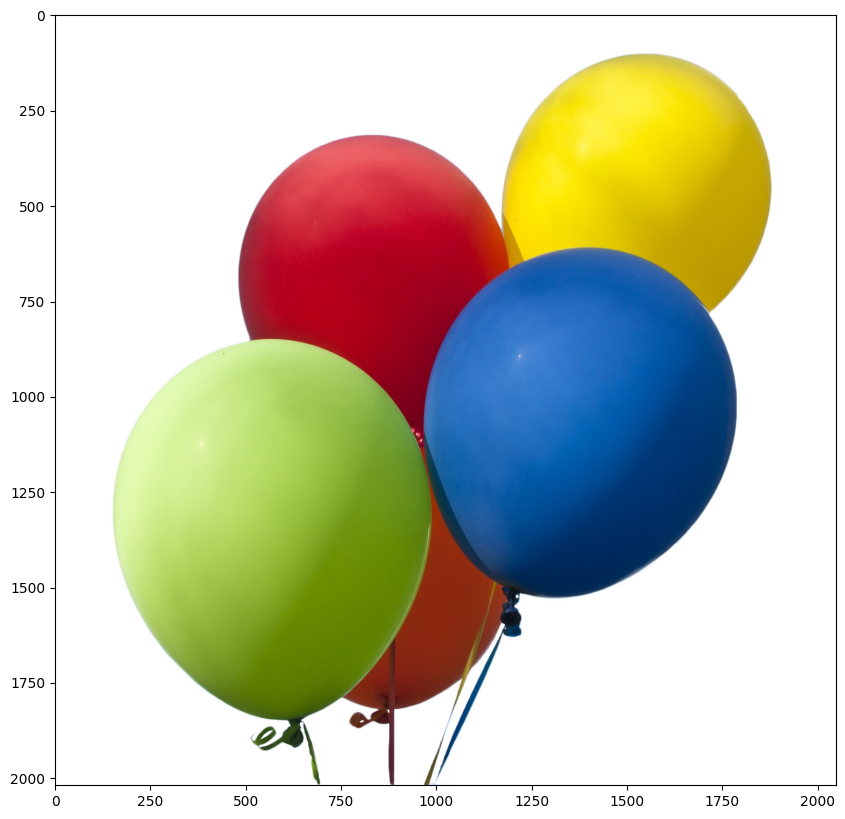

In [ ]:
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('ballondatasets/balloon/train/10464445726_6f1e3bbe6a_k.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the annotation format into the COCO format. Then we can use implemented COCODataset to load the data and perform training and evaluation.

In [ ]:
import os.path as osp

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = mmengine.load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(mmengine.track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        bboxes = []
        labels = []
        masks = []
        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (
                min(px), min(py), max(px), max(py))


            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id':0, 'name': 'balloon'}])
    mmengine.dump(coco_format_json, out_file)

In [ ]:
convert_balloon_to_coco(
    './ballondatasets/balloon/train/via_region_data.json',
    './ballondatasets/balloon/train/annotation_coco.json',
    './ballondatasets/balloon/train/')
convert_balloon_to_coco(
    './ballondatasets/balloon/val/via_region_data.json',
    './ballondatasets/balloon/val/annotation_coco.json',
    './ballondatasets/balloon/val/')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 30.7 task/s, elapsed: 2s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 29.9 task/s, elapsed: 0s, ETA:     0s


Checking the label corresponding to the instance split ID after the data format conversion is complete

In [ ]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = './ballondatasets/balloon/train/annotation_coco.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

display.clear_output()
# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

Category ID: 0, Category Name: balloon


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [ ]:
from mmengine import Config
cfg = Config.fromfile('./configs/rtmdet/rtmdet-ins_l_8xb32-300e_coco.py')

In [ ]:
from mmengine.runner import set_random_seed

# pre-training weight paths
cfg.load_from = 'checkpoints/rtmdet-ins_l_8xb32-300e_coco_20221124_103237-78d1d652.pth'

# working folder
cfg.work_dir = './work_dir'

# max epochs
cfg.max_epochs = 100
# stage2 epochs
cfg.stage2_num_epochs = 7
# batch size
cfg.train_dataloader.batch_size = 4
# dataloader num workers
cfg.train_dataloader.num_workers = 2

# scale factor
scale_factor = cfg.train_dataloader.batch_size / (8 * 32)

# scaling learning rate
cfg.base_lr *= scale_factor
cfg.optim_wrapper.optimizer.lr = cfg.base_lr

# freezing the layers of the backbone network
cfg.model.backbone.frozen_stages = -1
# number of classifications
cfg.model.bbox_head.num_classes = 1

# For single card training, you need to change SyncBN to BN
cfg.norm_cfg = dict(type='BN', requires_grad=True)

# labels and palettes(very important!!)
cfg.metainfo = {
    'classes': ('balloon', ),
    'palette': [
        (220, 20, 60),
    ]
}

# data folder
cfg.data_root = './ballondatasets/balloon'

# train json file path
cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
# train image file path
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

# valid json file path
cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
# valid image file path
cfg.val_dataloader.dataset.data_prefix.img = 'val/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo


cfg.test_dataloader = cfg.val_dataloader

# valid evaluator json file path
cfg.val_evaluator.ann_file = cfg.data_root+'/'+'val/annotation_coco.json'
# setting evaluation indicators
cfg.val_evaluator.metric = ['segm']

cfg.test_evaluator = cfg.val_evaluator

# model weights are saved every 10 intervals, up to two weights are saved at the same time, and the saving strategy is auto
cfg.default_hooks.checkpoint = dict(type='CheckpointHook', interval=10, max_keep_ckpts=2, save_best='auto')
# Interval of reporting indicators
cfg.default_hooks.logger.interval = 20

# switching training lanes to stage2 phase
cfg.custom_hooks[1].switch_epoch = 300 - cfg.stage2_num_epochs


cfg.train_cfg.max_epochs = cfg.max_epochs
# evaluation of the model begins at epoch 20
cfg.train_cfg.val_begin = 20
# evaluate the model every 2 epochs
cfg.train_cfg.val_interval = 2
cfg.train_cfg.dynamic_intervals = [(300 - cfg.stage2_num_epochs, 1)]

# the ballon dataset is small, so each epoch repeats the data 4 times
cfg.train_dataloader.dataset = dict(dict(type='RepeatDataset',times=4,dataset=cfg.train_dataloader.dataset))

# setting LinearLR strategy end step
cfg.param_scheduler[0].end = 100

# Setting the CosineAnnealingLR policy end eta_min, begin, end and T_max parameters
cfg.param_scheduler[1].eta_min = cfg.base_lr * 0.05
cfg.param_scheduler[1].begin = cfg.max_epochs // 2
cfg.param_scheduler[1].end = cfg.max_epochs
cfg.param_scheduler[1].T_max = cfg.max_epochs //2

# Fixed random number seed
set_random_seed(0, deterministic=False)

# cfg.visualizer.vis_backends.append({"type":'WandbVisBackend'})

#------------------------------------------------------
config=f'./configs/rtmdet/rtmdet-ins_l_1xb4-100e_ballon.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

## Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [ ]:
!python tools/train.py {config}

07/23 23:25:30 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
    CUDA available: True
    numpy_random_seed: 1236505372
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_

## Understand the log
From the log, we can have a basic understanding on the training process and know how well the detector is trained.

Since the dataset we are using is small, we loaded a RTMDet model and finetune it for detection. Because the original RTMDet is trained on COCO dataset that contains 80 classes but balloon dataset only have 1 classes.

Aafter training, the detector is evaluated by the default COCO-style evaluation. The results show that the detector achieves 64.3 mask AP on the val dataset, not bad!

 We can also check the tensorboard to see the curves.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir work_dir/

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

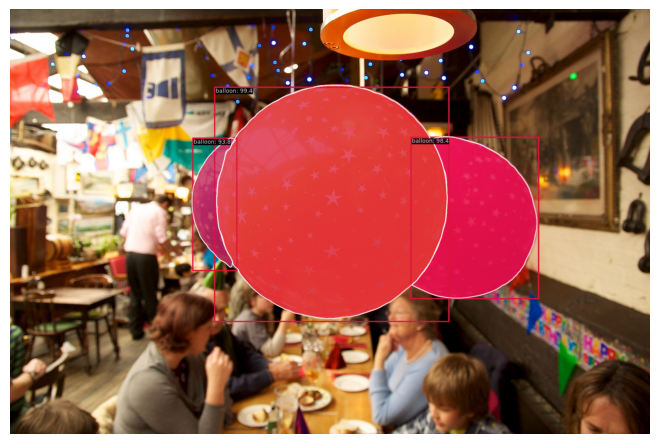

In [ ]:
from mmengine.visualization import Visualizer
import mmcv
from mmdet.apis import init_detector, inference_detector
import glob

img = mmcv.imread('./ballondatasets/balloon/train/7178882742_f090f3ce56_k.jpg',channel_order='rgb')

checkpoint_file = glob.glob('./work_dir/best_coco_segm_mAP*.pth')[0]

model = init_detector(cfg, checkpoint_file, device='cuda:0')

new_result = inference_detector(model, img)

visualizer_now = Visualizer.get_current_instance()

visualizer_now.dataset_meta = model.dataset_meta

visualizer_now.add_datasample('new_result', img, data_sample=new_result, draw_gt=False, wait_time=0, out_file=None, pred_score_thr=0.5)

display.clear_output()

visualizer_now.show()

## What to Do Next?

So far, we have learnt how to test and train RTMDet. To further explore the segmentation task, you could do several other things as shown below:

- Try two stage or sota models methods, e.g., [Mask R-CNN](https://github.com/matterport/Mask_RCNN) and [Mask2Former](https://github.com/facebookresearch/Mask2Former). These two algorithms are based on MMDetection.
- Try semantic segmentation. Semantic segmentation is also a popular task with wide applications. You can explore [MMSegmentation](https://github.com/open-mmlab/mmsegmentation/); we also provide a [colab tutorial](https://github.com/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb) for semantic segmentation using MMSegmentation.
